In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
cd gdrive/MyDrive/NESTQUANT/data

/content/gdrive/MyDrive/NESTQUANT/data


## import lib and create function

In [3]:
import os
import gc
import math
import sklearn
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [4]:
from datetime import datetime

In [ ]:
def get_return(df, time, name):
    dff = df.copy()
    dff[f'RETURN_{name}_{time}'] = np.log(dff[f'CLOSE_{name}'] / dff[f'CLOSE_{name}'].shift(time))
    return dff

def get_vola(df, time, isReturn, name):
    dff = df.copy()
    if isReturn == False:
        dff = get_return(dff, 1)
    dff[f"std_{time}"] = dff[f'RETURN_{name}_1'].rolling(window=time).std()
    dff["std_long"] = dff[f'RETURN_{name}_1'].rolling(window=336).std()
    dff[f"VOLABILITY_{name}_{time}"]  = dff[f"std_{time}"]/ dff["std_long"]

    dff = dff.drop(f"std_{time}", axis = 1)
    dff = dff.drop("std_long", axis = 1)

    return dff


def preprocess_df(df, name, start, end):
    for col in df.columns:
        if (col == 'YEAR_AND_MONTH') | (col =="SYMBOL"):
            df = df.drop(col, axis = 1)
        else:
            df[f'{col}_{name}'] = df[col]
            df = df.drop(col, axis = 1)

    for i in range(start, end):
        df = get_return(df, i, name)
        if i == 1:
            continue
        else:
            df = get_vola(df, i, True, name)

    return df


# Original dataframe
def get_dupp(dff):
# Convert the 'date' column to datetime type
    dff['DATE'] = pd.to_datetime(dff['DATE'])

    # Create a new dataframe to store the expanded rows
    expanded_dff = pd.DataFrame()

    # Iterate over each row in the original dataframe
    for index, row in dff.iterrows():
        date = row['DATE']
        values = row[1:]  # Exclude the 'date' column

        # Create a datetime range for the 24 hours of the day
        hour_range = pd.date_range(date, periods=24, freq='H')

        # Create a temporary dataframe with the expanded rows
        temp_dff = pd.DataFrame(hour_range, columns=['DATE'])

        # Duplicate the values for each hour
        for column, value in zip(dff.columns[1:], values):
            temp_dff[column] = value

        # Append the temporary dataframe to the expanded dataframe
        expanded_dff = expanded_dff.append(temp_dff, ignore_index=True)
    return expanded_dff


## Read and preprocess data

In this part, we can optimize the model by adding more external data from other sources: crypto, stocks,... and internal data: return, volumne

In [5]:
"""
optimizable
"""
path = '/content/gdrive/MyDrive/NESTQUANT/data/'

"""
BTC data path
"""
path_BTC = path + 'BTC/BTCUSDT_obeserved.csv'
path_LABEL = path + 'BTC/BTCUSDT_label.csv'

"""
external data path
"""
path_ETHUSDT = path+ 'coin/ETHUSDT'
path_LTCUSDT = path+ 'coin/LTCUSDT'
path_CPILFESL = path + 'FRED/CPILFESL.parquet'
path_EURUSD = path + 'fx/C_EURUSD'
path_SPY = path+'stock/SPY'

"""
Add more external datapath in here

"""


In [7]:
"""
BTC preprocessing
""" 
df_Label = pd.read_csv(path_BTC)
df_BTC = pd.read_csv(path_LABEL)
df_Label = df_Label.set_index("OPEN_TIME")
df_BTC = df_BTC.set_index("OPEN_TIME")
df_BTCLabel = df_BTC.join(df_Label, how='inner')
df_BTCLabel = df_BTCLabel.drop(columns=["YEAR_AND_MONTH","SYMBOL"])

In [ ]:
"""
optimizable
"""

"""
External preprocessing
"""
df_BTCLabel = preprocess_df(df_BTCLabel, "BTC",1, 24)
df_ETHUSDT = preprocess_df(pd.read_parquet(path_ETHUSDT),"ETHUSDT", 1, 24)
df_LTCUSDT = preprocess_df(pd.read_parquet(path_LTCUSDT),"LTCUSDT",1, 24)
df_EURUSD = preprocess_df(pd.read_parquet(path_EURUSD),"EURUSD", 1, 24)
df_SPY = preprocess_df(pd.read_parquet(path_SPY),"SPY", 1, 24)
"""
add more external data with external path
"""


In [ ]:
df_BTCLabel = df_BTCLabel.dropna()
df_ETHUSDT = df_ETHUSDT.dropna()
df_LTCUSDT = df_LTCUSDT.dropna()
df_EURUSD = df_EURUSD.dropna()
df_SPY = df_SPY.dropna()

In [ ]:
df_CPILFESL = pd.read_parquet(path_CPILFESL)
df_CPILFESL = get_dupp(df_CPILFESL)
df_CPILFESL["OPEN_TIME"] = df_CPILFESL["DATE"].apply(lambda x: int(datetime.timestamp(x)) *1000)
df_CPILFESL = df_CPILFESL.drop("DATE", axis= 1)
df_CPILFESL = df_CPILFESL.set_index("OPEN_TIME")

Merge external data

In [13]:
df_BTCLabel1 = df_BTCLabel.join(df_ETHUSDT, how = 'inner')
df_BTCLabel2 = df_BTCLabel1.join(df_EURUSD, how="left").bfill().ffill()
df_BTCLabel3 = df_BTCLabel2.join(df_LTCUSDT, how="left").bfill().ffill()
df_BTCLabel4 = df_BTCLabel3.join(df_SPY, how="left").bfill().ffill()
df_BTCLabel5 = df_BTCLabel4.join(df_CPILFESL, how="left").bfill().ffill().reset_index()

Get features from dataframe, here I just only get:  "OPEN_TIME","OPEN_BTC","HIGH_LTCUSDT","LABEL_BTC","VOLABILITY_BTC_23", however, we can get moreeee

In [14]:
"""
optimizable
"""

df_BTCLabel5  = df_BTCLabel5[["OPEN_TIME","OPEN_BTC","HIGH_LTCUSDT","LABEL_BTC","VOLABILITY_BTC_23"]]

In [15]:
df_BTCLabel5

,OPEN_TIME,OPEN_BTC,HIGH_LTCUSDT,LABEL_BTC,VOLABILITY_BTC_23
0,1.506766e+12,4280.00,288.99,0.418041,0.954160
1,1.506769e+12,4340.00,288.99,0.432839,0.969136
2,1.506773e+12,4320.21,288.99,0.440061,0.969638
3,1.506776e+12,4306.00,288.99,0.417250,0.893626
4,1.506780e+12,4286.82,288.99,0.388672,0.907736
...,...,...,...,...,...
47321,1.677611e+12,23481.63,95.15,0.448246,0.500673
47322,1.677614e+12,23263.38,94.64,0.470401,0.634515
47323,1.677618e+12,23270.59,94.22,0.468764,0.622967
47324,1.677622e+12,23138.89,93.52,0.474988,0.612269


## Model training

take train, test data

In [22]:
x = df_BTCLabel5.drop(['LABEL_BTC'],axis=1)
y = df_BTCLabel5["LABEL_BTC"]

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.1, shuffle=False)


In [18]:
time = x_train.OPEN_TIME.tolist()

Training

In [20]:
"""
optimizable
"""

"""
Here, I use rolling training with the delta = 24 mean that we update the model in every 24h 
(model just only learn in 24h).
start_training_OPEN_TIME = 1000 mean that we start to learn model from time stamp: OPEN_TIME+1000 hour

"""


delta = 24 #optimzable
start_training_OPEN_TIME = 1000
model_predicted_scores = []


for i in range(start_training_OPEN_TIME, len(time), delta):
    tmp_train_df = df_BTCLabel5[(df_BTCLabel5.OPEN_TIME >= time[i-start_training_OPEN_TIME])&(df_BTCLabel5.OPEN_TIME < time[i-delta//2])]
    x_trainn = tmp_train_df.drop(['LABEL_BTC'],axis=1)
    y_trainn = tmp_train_df["LABEL_BTC"]

    tmp_valid_df = df_BTCLabel5[(df_BTCLabel5.OPEN_TIME >= time[i-delta//2])&(df_BTCLabel5.OPEN_TIME < time[i])]
    x_validd = tmp_valid_df.drop(['LABEL_BTC'],axis=1)
    y_validd = tmp_valid_df["LABEL_BTC"]

    tmp_test_df = df_BTCLabel5[(df_BTCLabel5.OPEN_TIME >= time[i])&(df_BTCLabel5.OPEN_TIME < time[i+delta])]
    x_testt = tmp_test_df.drop(['LABEL_BTC'],axis=1)
    y_testt = tmp_test_df["LABEL_BTC"]

    train_data = lgb.Dataset(x_trainn, label=pd.DataFrame(y_trainn), params={'verbose': -1})
    valid_data = lgb.Dataset(pd.DataFrame(x_validd), label=pd.DataFrame(y_validd), params={'verbose': -1}, reference=train_data)

    print("Train, Valid, Test size: ", x_trainn.shape[0], x_validd.shape[0], x_testt.shape[0])
     
    """
    optimizable
    """ 
    param = {
        'boosting_type': 'goss',
        'max_depth': 4,
        'num_leaves': 15,
        'learning_rate': 0.08,
        'objective': "regression",
        'early_stopping_rounds': 64,
        'metric': 'mse',
        'num_boost_round': 100,
        'num_iterations': 512
    #     'bagging_fraction': 0.8
    }

    model = lgb.train(
        param,
        train_data,
        valid_sets=[train_data, valid_data],
        valid_names=['train', 'valid'],
        verbose_eval=False
    )
    model_predicted_scores.append([(model.predict(x_trainn)-y_trainn).abs().mean(), (model.predict(x_validd)-y_validd).abs().mean(), (model.predict(x_testt)-y_testt).abs().mean()])




Output hidden; open in https://colab.research.google.com to view.

In [21]:
x_test

,OPEN_TIME,OPEN_BTC,HIGH_LTCUSDT,VOLABILITY_BTC_23
42568,1.660500e+12,24229.10,63.16,0.671485
42569,1.660504e+12,24286.74,63.62,0.677747
42570,1.660507e+12,24284.07,63.40,0.645924
42571,1.660511e+12,24313.51,63.42,0.646481
42572,1.660514e+12,24344.88,63.43,0.640665
42573,1.660518e+12,24257.90,63.41,0.641532
42574,1.660522e+12,24305.25,63.19,0.601173
42575,1.660525e+12,24400.97,63.83,0.623957
42576,1.660529e+12,24645.14,64.15,0.784573
42577,1.660532e+12,24918.29,64.94,0.886613


In [23]:
x_test

,OPEN_TIME,OPEN_BTC,HIGH_LTCUSDT,VOLABILITY_BTC_23
42593,1.660590e+12,24098.22,60.91,1.320533
42594,1.660594e+12,23983.54,60.82,1.327271
42595,1.660597e+12,24068.36,60.90,1.335188
42596,1.660601e+12,24027.43,60.65,1.339145
42597,1.660604e+12,24013.72,60.23,1.358235
...,...,...,...,...
47321,1.677611e+12,23481.63,95.15,0.500673
47322,1.677614e+12,23263.38,94.64,0.634515
47323,1.677618e+12,23270.59,94.22,0.622967
47324,1.677622e+12,23138.89,93.52,0.612269


In [ ]:
y_test

42593    0.401599
42594    0.405856
42595    0.406372
42596    0.395813
42597    0.391707
           ...   
47321    0.448246
47322    0.470401
47323    0.468764
47324    0.474988
47325    0.484824
Name: LABEL_BTC, Length: 4733, dtype: float64

In [36]:
pred=model.predict(x_test)
submit=pd.DataFrame(columns=['OPEN_TIME','PREDICTION'])
submit['OPEN_TIME']=x_test["OPEN_TIME"]
submit['PREDICTION']=pred.flatten()

testt=pd.DataFrame(columns=['TEST','PREDICTION'])

testt['TEST']=y_test
testt['PREDICTION']=pred.flatten()


In [25]:
testt.corr()

,TEST,PREDICTION
TEST,1.000000,0.039486
PREDICTION,0.039486,1.000000


In [32]:
path = '/content/gdrive/MyDrive/NESTQUANT/data/predicted_data/'

In [33]:
submit.to_csv(path+ "Vol23_OPENBTC_LTCHIGH.csv")

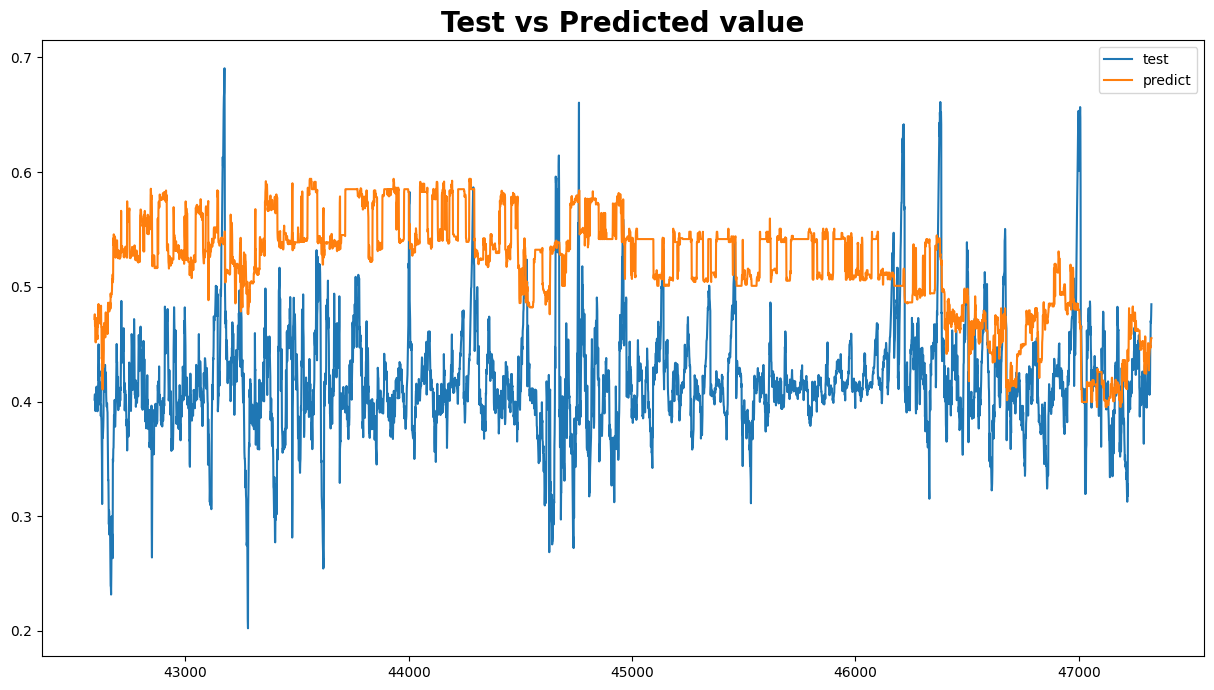

In [26]:
fig=plt.figure(figsize=(15,8))
plt.title("Test vs Predicted value", size=20, weight='bold')
plt.plot(testt)
plt.legend(['test','predict'])


In [35]:
path_model = '/content/gdrive/MyDrive/NESTQUANT/models/'
model.save_model(path_model+"UpdatedBestmodel.txt")